# LDA Topic Extraction

## Goal: 
In this notebook I will finally begin extracting the topics from the arXiv abstracts using Latent Dirilicht Allocation.  The purpose of this is to tune the LDA algorithm which will output the generalized topics in an unsupervised setting.  While we have the general topics (as seen in the arXiv_PrelimEDA notebook), we noticed that almost all of the text are cross-topics.  Additionally, the topics on the arXiv are too broad strokes as well.  

I will note however, if we were to use ADS then the keywords are likely already presented and will be easier to extract.  However, in the case where we want to extend our analysis to fields other than Astronomy and Astrophysics (which ADS does not have), then understanding how well we perform here is critical.  

In [191]:
import spacy
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import json

import numpy as np 
import scipy as sp
from scipy import signal
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
%cd ../arXiv_MetadataExtraction

/Users/nakulgangolli/Desktop/arXiv_Reader/arXiv_MetadataExtraction


In [27]:
df = pd.read_csv('cleaned_arxiv_astro.csv')
print(df.head)

<bound method NDFrame.head of        Unnamed: 0      arXiv_ID  \
0               0   1001.5035v1   
1               1   1001.3428v2   
2               2   1001.1630v1   
3               3   1001.1738v3   
4               4   1001.2316v1   
...           ...           ...   
88135       88135  2507.03399v1   
88136       88136  2507.03561v1   
88137       88137  2507.03583v2   
88138       88138  2507.03882v1   
88139       88139  2507.04266v1   

                                                   title  \
0      The VIRUS-P Exploration of Nearby Galaxies (VE...   
1      The Rise and Fall of Type Ia Supernova Light C...   
2      The radio properties of a complete, X-ray sele...   
3      SDSS J1254+0846: A Binary Quasar Caught in the...   
4      Intermediate Mass Ratio Black Hole Binaries: N...   
...                                                  ...   
88135  CME activities on spotless days during descend...   
88136  Modelling delta Scuti pulsations: A new grid o...   
88137  Im

In [28]:
CLEANED_ABSTRACT_LIST = df['Cleaned Abstracts'].values

In [29]:
print(CLEANED_ABSTRACT_LIST[2:10])

['investigate radio property complete sample nearby massive xray bright elliptical galaxy sample contain galaxy rosat allsky survey xray flux distance galaxy complete radio chandra xray coverage nuclear radio emission detect galaxy galaxy exhibit extend radio emission exhibit clear evidence interaction radio source surround xray emit galaxy unresolved radio source clear small cavitylike feature chandra xray image disturb xray morphology radio luminosity limit equivalent calculate radioloud fraction miss majority radio detect galaxy sample determine integrate radiotoxray flux ratio galaxy span large range factor calculate massweighted cool time hint anticorrelation radio luminosity calculate limit ratio total particle energy relativistic electron radiate range volume factor plasma cavity distribution broad reflect previous large galaxy cluster lower xray flux limit expense complete chandra coverage increase size sample galaxy nuclear radio activity detect extended sample'
 'luminous spa

In [30]:
import gensim
from gensim import corpora
from gensim.models import Phrases 
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

BAD_ABSTRACT = 0
TOKENIZED_ABSTRACT_LIST = []
for idx, ABSTRACT in enumerate(CLEANED_ABSTRACT_LIST): 
    try:
        TOKENIZED_ABSTRACT_LIST.append(ABSTRACT.split(' '))
    except:
        CLEANED_ABSTRACT_LIST = np.delete(CLEANED_ABSTRACT_LIST, idx)
        BAD_ABSTRACT += 1 
        print("Something weird is going on with this abstract")

print(F"Total Number of Abstracts: {len(TOKENIZED_ABSTRACT_LIST)} \t Number of Bad Abstracts: {BAD_ABSTRACT}")

ARXIV_CONNECTOR_WORDS = list(ENGLISH_CONNECTOR_WORDS)# +['dark', 'black', 'physical', 
                                                     #   galactic', 'stellar', 'primordial']
print(ARXIV_CONNECTOR_WORDS)

bigrams = Phrases(TOKENIZED_ABSTRACT_LIST, min_count=2, threshold=10., max_vocab_size=40000, connector_words=ARXIV_CONNECTOR_WORDS)
bigram_model = gensim.models.phrases.Phraser(bigrams)

BIGRAM_ABSTRACT_LIST = [bigram_model[ABSTRACT] for ABSTRACT in TOKENIZED_ABSTRACT_LIST]
print(BIGRAM_ABSTRACT_LIST[0])
# Create Dictionary and Corpus

# print(LDA_ABSTRACT_LIST[:10])
dictionary = corpora.Dictionary(BIGRAM_ABSTRACT_LIST)
dictionary.filter_extremes(no_below=5, no_above=0.95)
corpus = [dictionary.doc2bow(ABSTRACT) for ABSTRACT in BIGRAM_ABSTRACT_LIST]


Something weird is going on with this abstract
Total Number of Abstracts: 88139 	 Number of Bad Abstracts: 1
['by', 'a', 'on', 'and', 'of', 'or', 'to', 'without', 'in', 'at', 'with', 'an', 'the', 'for', 'from']
['venga', 'largescale', 'extragalactic', 'survey', 'bulge', 'large', 'outer', 'disk', 'nearby', 'normal', 'spiral', 'galaxy', 'target', 'choose', 'span', 'wide', 'range', 'hubble', 'type', 'star', 'formation', 'activity', 'morphology', 'inclination', 'time', 'vast', 'available', 'multiwavelength', 'coverage', 'faruv', 'midir', 'available', 'mapping', 'venga', 'provide', 'stellar', 'kinematic', 'chemical', 'abundance', 'density', 'ionization', 'state', 'dust', 'extinction', 'stellar', 'population', 'galaxy', 'uniqueness', 'virusp', 'large', 'field', 'view', 'permit', 'largescale', 'mapping', 'perform', 'venga', 'allow', 'correlate', 'important', 'quantity', 'different', 'environment', 'galactic', 'disk', 'allow', 'conduction', 'large', 'number', 'star', 'formation', 'structure', 

In [31]:
# topic_model.visualize_topics()

In [114]:
from gensim.models import LdaModel

NTOPICS = 10
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NTOPICS,         # Change to desired number of topics
    random_state=1008,
    passes=20,
    alpha='auto',
    per_word_topics=True,
    iterations=200
    # chunksize = len(CLEANED_ABSTRACT_LIST)//50
)

In [115]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings("ignore")

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [135]:
def get_TopicKeyWords(_lda_model, _TOPIC_NUM): 
    _TOPICS = _lda_model.print_topics(num_words=10)
    words = _lda_model.show_topic(_TOPIC_NUM, topn=10) 
    keywords = ", ".join([word for word, _ in words])
    # print(f"Topic {topic_num}: {topic}")
    return keywords

def get_dominant_topic(_abstract_BOW, _ldamodel):

    # Derive the topics from the Bag-of-Words
    # from the abstract. 
    topics = _ldamodel.get_document_topics(_abstract_BOW)

    # Sort topics based on probability, in descedning 
    # order.  
    topics = sorted(topics, key=lambda x: x[1])[::-1]

    # Select topics that this abstract belongs, have a 
    # cutoff for the probability that a given abstract 
    # belongs to a specific topic
    _PROB_THRESHOLD = 0.4 # the 
    counter, tot_prob = 0, 0.
    return_topics = []
    while tot_prob < _PROB_THRESHOLD:
        return_topics.append(topics[counter])
        tot_prob += topics[counter][1]
        counter += 1 
    # print(return_topics, tot_prob)
    return return_topics # topics[0] if topics else (None, 0.0)

ABSTRACT_TOPIC_LIST = []
# Assign dominant topic to each abstract
for idx, abstract in enumerate(CLEANED_ABSTRACT_LIST):
    abstract_BOW = corpus[idx]
    topics = get_dominant_topic(abstract_BOW, lda_model)
    ABSTRACT_TOPIC_LIST.append(topics)
    # print(ABSTRACT_TOPIC_LIST[idx])
    # print(f"Abstract {idx} => Topic {topic_id} (confidence: {prob:.2f})")

[(3, 0.30799595), (9, 0.27831444)]
[(2, 0.4141821)]
[(8, 0.58973604)]
[(3, 0.265612), (8, 0.2611474)]
[(4, 0.3111155), (5, 0.2847481)]
[(3, 0.62602127)]
[(0, 0.497046)]
[(5, 0.61197424)]
[(0, 0.74661547)]
[(2, 0.63079745)]
[(5, 0.29024872), (7, 0.25081173)]
[(5, 0.52276057)]
[(5, 0.42511475)]
[(8, 0.6874851)]
[(9, 0.68613225)]
[(5, 0.3401448), (4, 0.3361267)]
[(9, 0.44182014)]
[(2, 0.31047645), (1, 0.20506239)]
[(6, 0.44519195)]
[(6, 0.3318566), (4, 0.31344303)]
[(3, 0.4823263)]
[(5, 0.39501718), (3, 0.31681433)]
[(6, 0.66118413)]
[(9, 0.38051826), (1, 0.19971918)]
[(6, 0.3685062), (8, 0.25122744)]
[(5, 0.41518322)]
[(5, 0.50421953)]
[(5, 0.5463342)]
[(4, 0.4831356)]
[(3, 0.44952783)]
[(6, 0.36845627), (5, 0.32731313)]
[(9, 0.7111531)]
[(5, 0.4349114)]
[(9, 0.42126197)]
[(5, 0.3987566), (3, 0.22080141)]
[(5, 0.48041412)]
[(8, 0.27974918), (5, 0.25100768)]
[(3, 0.41378126)]
[(5, 0.24043663), (3, 0.18798724)]
[(3, 0.5161734)]
[(3, 0.53717846)]
[(5, 0.29123965), (0, 0.27177313)]
[(5, 0.61

In [137]:
topic_dict = {}
for idx, topic_list in enumerate(ABSTRACT_TOPIC_LIST): 
    for _ in range(len(topic_list)):
        if _ not in topic_dict:
            topic_dict[_] = [[df['arXiv_ID'][idx], df['Month'][idx], df['Year'][idx], \
                              df['title'][idx], df['authors'][idx], \
                              df['abstract'][idx], df['Cleaned Abstracts'][idx], topic_list[_][0]]]
        else:
            topic_dict[_].append([df['arXiv_ID'][idx], df['Month'][idx], df['Year'][idx], \
                              df['title'][idx], df['authors'][idx], \
                              df['abstract'][idx], df['Cleaned Abstracts'][idx], topic_list[_][0]])

for key in topic_dict.keys():
    print(f"Number of Topics: {len(topic_dict[key])}")

# print(topic_dict[0])

Number of Topics: 88139
Number of Topics: 25279
Number of Topics: 140


In [138]:
df_FirstTopic = pd.DataFrame(topic_dict[0], columns=['arXiv_ID', 'Month', 'Year', 
                                                     'Title', 'Authors', 
                                                     'Abstract', 'Cleaned Abstract',
                                                     'Topic'])
print(df_FirstTopic)

           arXiv_ID  Month  Year  \
0       1001.5035v1      1  2010   
1       1001.3428v2      1  2010   
2       1001.1630v1      1  2010   
3       1001.1738v3      1  2010   
4       1001.2316v1      1  2010   
...             ...    ...   ...   
88134  2507.03296v1      7  2025   
88135  2507.03399v1      7  2025   
88136  2507.03561v1      7  2025   
88137  2507.03583v2      7  2025   
88138  2507.03882v1      7  2025   

                                                   Title  \
0      The VIRUS-P Exploration of Nearby Galaxies (VE...   
1      The Rise and Fall of Type Ia Supernova Light C...   
2      The radio properties of a complete, X-ray sele...   
3      SDSS J1254+0846: A Binary Quasar Caught in the...   
4      Intermediate Mass Ratio Black Hole Binaries: N...   
...                                                  ...   
88134  Acceleration of Solar Eruptions via Enhanced T...   
88135  CME activities on spotless days during descend...   
88136  Modelling delta Scut

In [158]:
def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w


In [217]:
import numpy as np 

timeLine = np.zeros((NTOPICS, len(range(2010, 2026))*len(range(1, 13))))
timeLine = timeLine[:,:175]
# print(timeLine, timeLine[0], timeLine[1])
countTopicOverTime = pd.DataFrame(df_FirstTopic.groupby(['Year', 'Month', 'Topic']).count())
countTopicOverTime = countTopicOverTime.reset_index().sort_index()
yy = 0
for YY, YEAR in enumerate(range(2010, 2026)):
    for MM, MONTH in enumerate(range(1, 13)):
        if YY*12+MM >= 175: break
        
        _ = df_FirstTopic[np.logical_and(df_FirstTopic['Year'] == YEAR, df_FirstTopic['Month'] == MONTH)]['Topic']
        _TOPICS, _COUNT = np.unique(_, return_counts=True)
        # print(f"{MONTH}/{YEAR}: Topic List: {_TOPICS} \t Number of Occurrences: {_COUNT}")
        
        for topicNum in range(NTOPICS):
            # print(topicNum not in _TOPICS, topicNum, timeLine[topicNum], _COUNT[np.where(topicNum == _TOPICS)])
            if topicNum not in _TOPICS:
                timeLine[topicNum][YY*12+MM] = 0
            else:
                timeLine[topicNum][YY*12+MM] = _COUNT[np.where(topicNum == _TOPICS)[0][0]]

# print(np.shape(timeLine))
# print(timeLine[0,:])

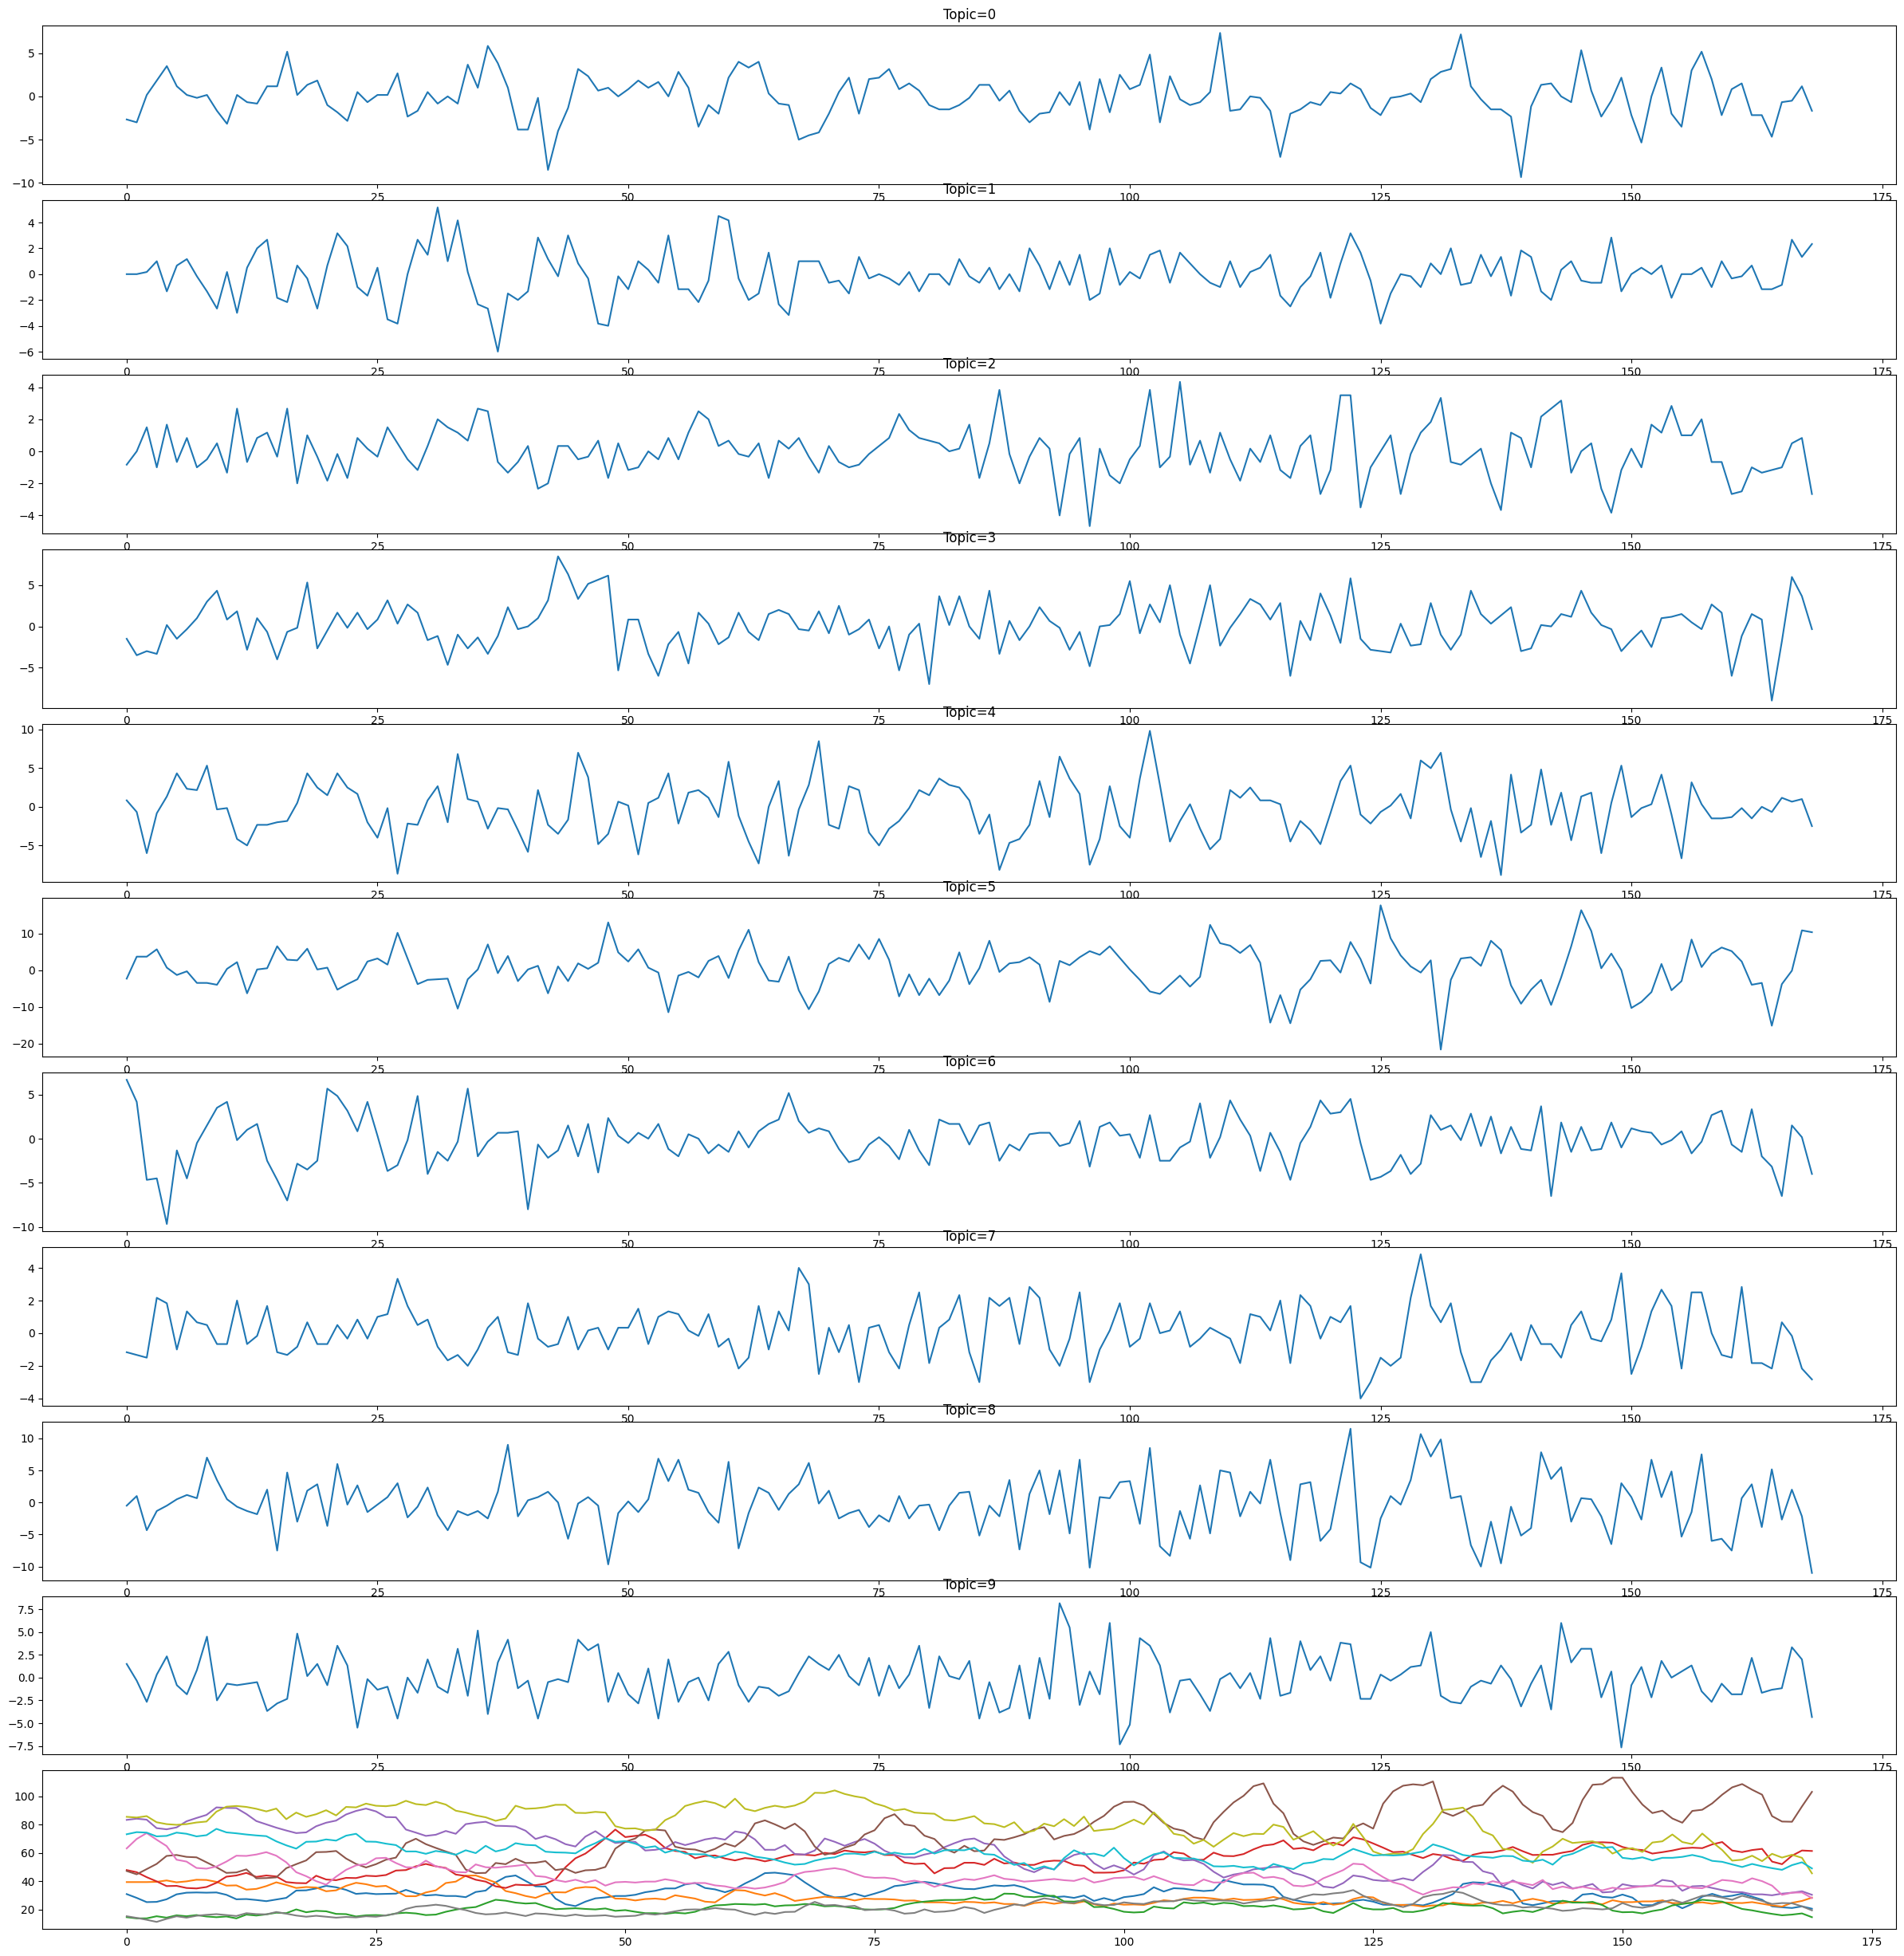

In [311]:

fig, ax = plt.subplots(figsize=(30,3*len(timeLine)+1), nrows=NTOPICS+1, gridspec_kw={'hspace':0.1, 'wspace':0.1})
# fig, ax = plt.subplots(figsize=(30,30), gridspec_kw={'hspace':0.1, 'wspace':0.1})
for idx, _ in enumerate(timeLine):
    rolling_mean = moving_average(_, 6)
    ylimits = [np.amin(rolling_mean[np.where(rolling_mean > 15)[0]])-5, np.amax(rolling_mean)+5]
    # ax[idx].plot(np.arange(len(rolling_mean)),rolling_mean, label=f'Topic: {idx}')
    ax[idx].plot(np.arange(len(rolling_mean)-1), np.diff(rolling_mean), label=f'Topic: {idx}')
    ax[len(ax)-1].plot(np.arange(len(rolling_mean)),rolling_mean, label=f'Topic: {idx}')
    ax[idx].set_title(f"Topic={idx}")
    # ax[idx].set_ylim(ylimits[0], ylimits[1])


fig.show()
    

# print(countTopicOverTime)

In [317]:
def autoCorrelate(series):
    from scipy import signal

    return signal.correlate(series, series, mode='same') # / len(series)

def fourier_analysis(series, sampling_interval=6):
    from scipy.fft import fft, fftfreq
    series /= np.sum(series)
    N = len(series)
    yf = fft(series) #-series.mean())
    xf = fftfreq(N, d=sampling_interval)
    return xf[:N//2], yf[:N//2]  # Only positive frequencies

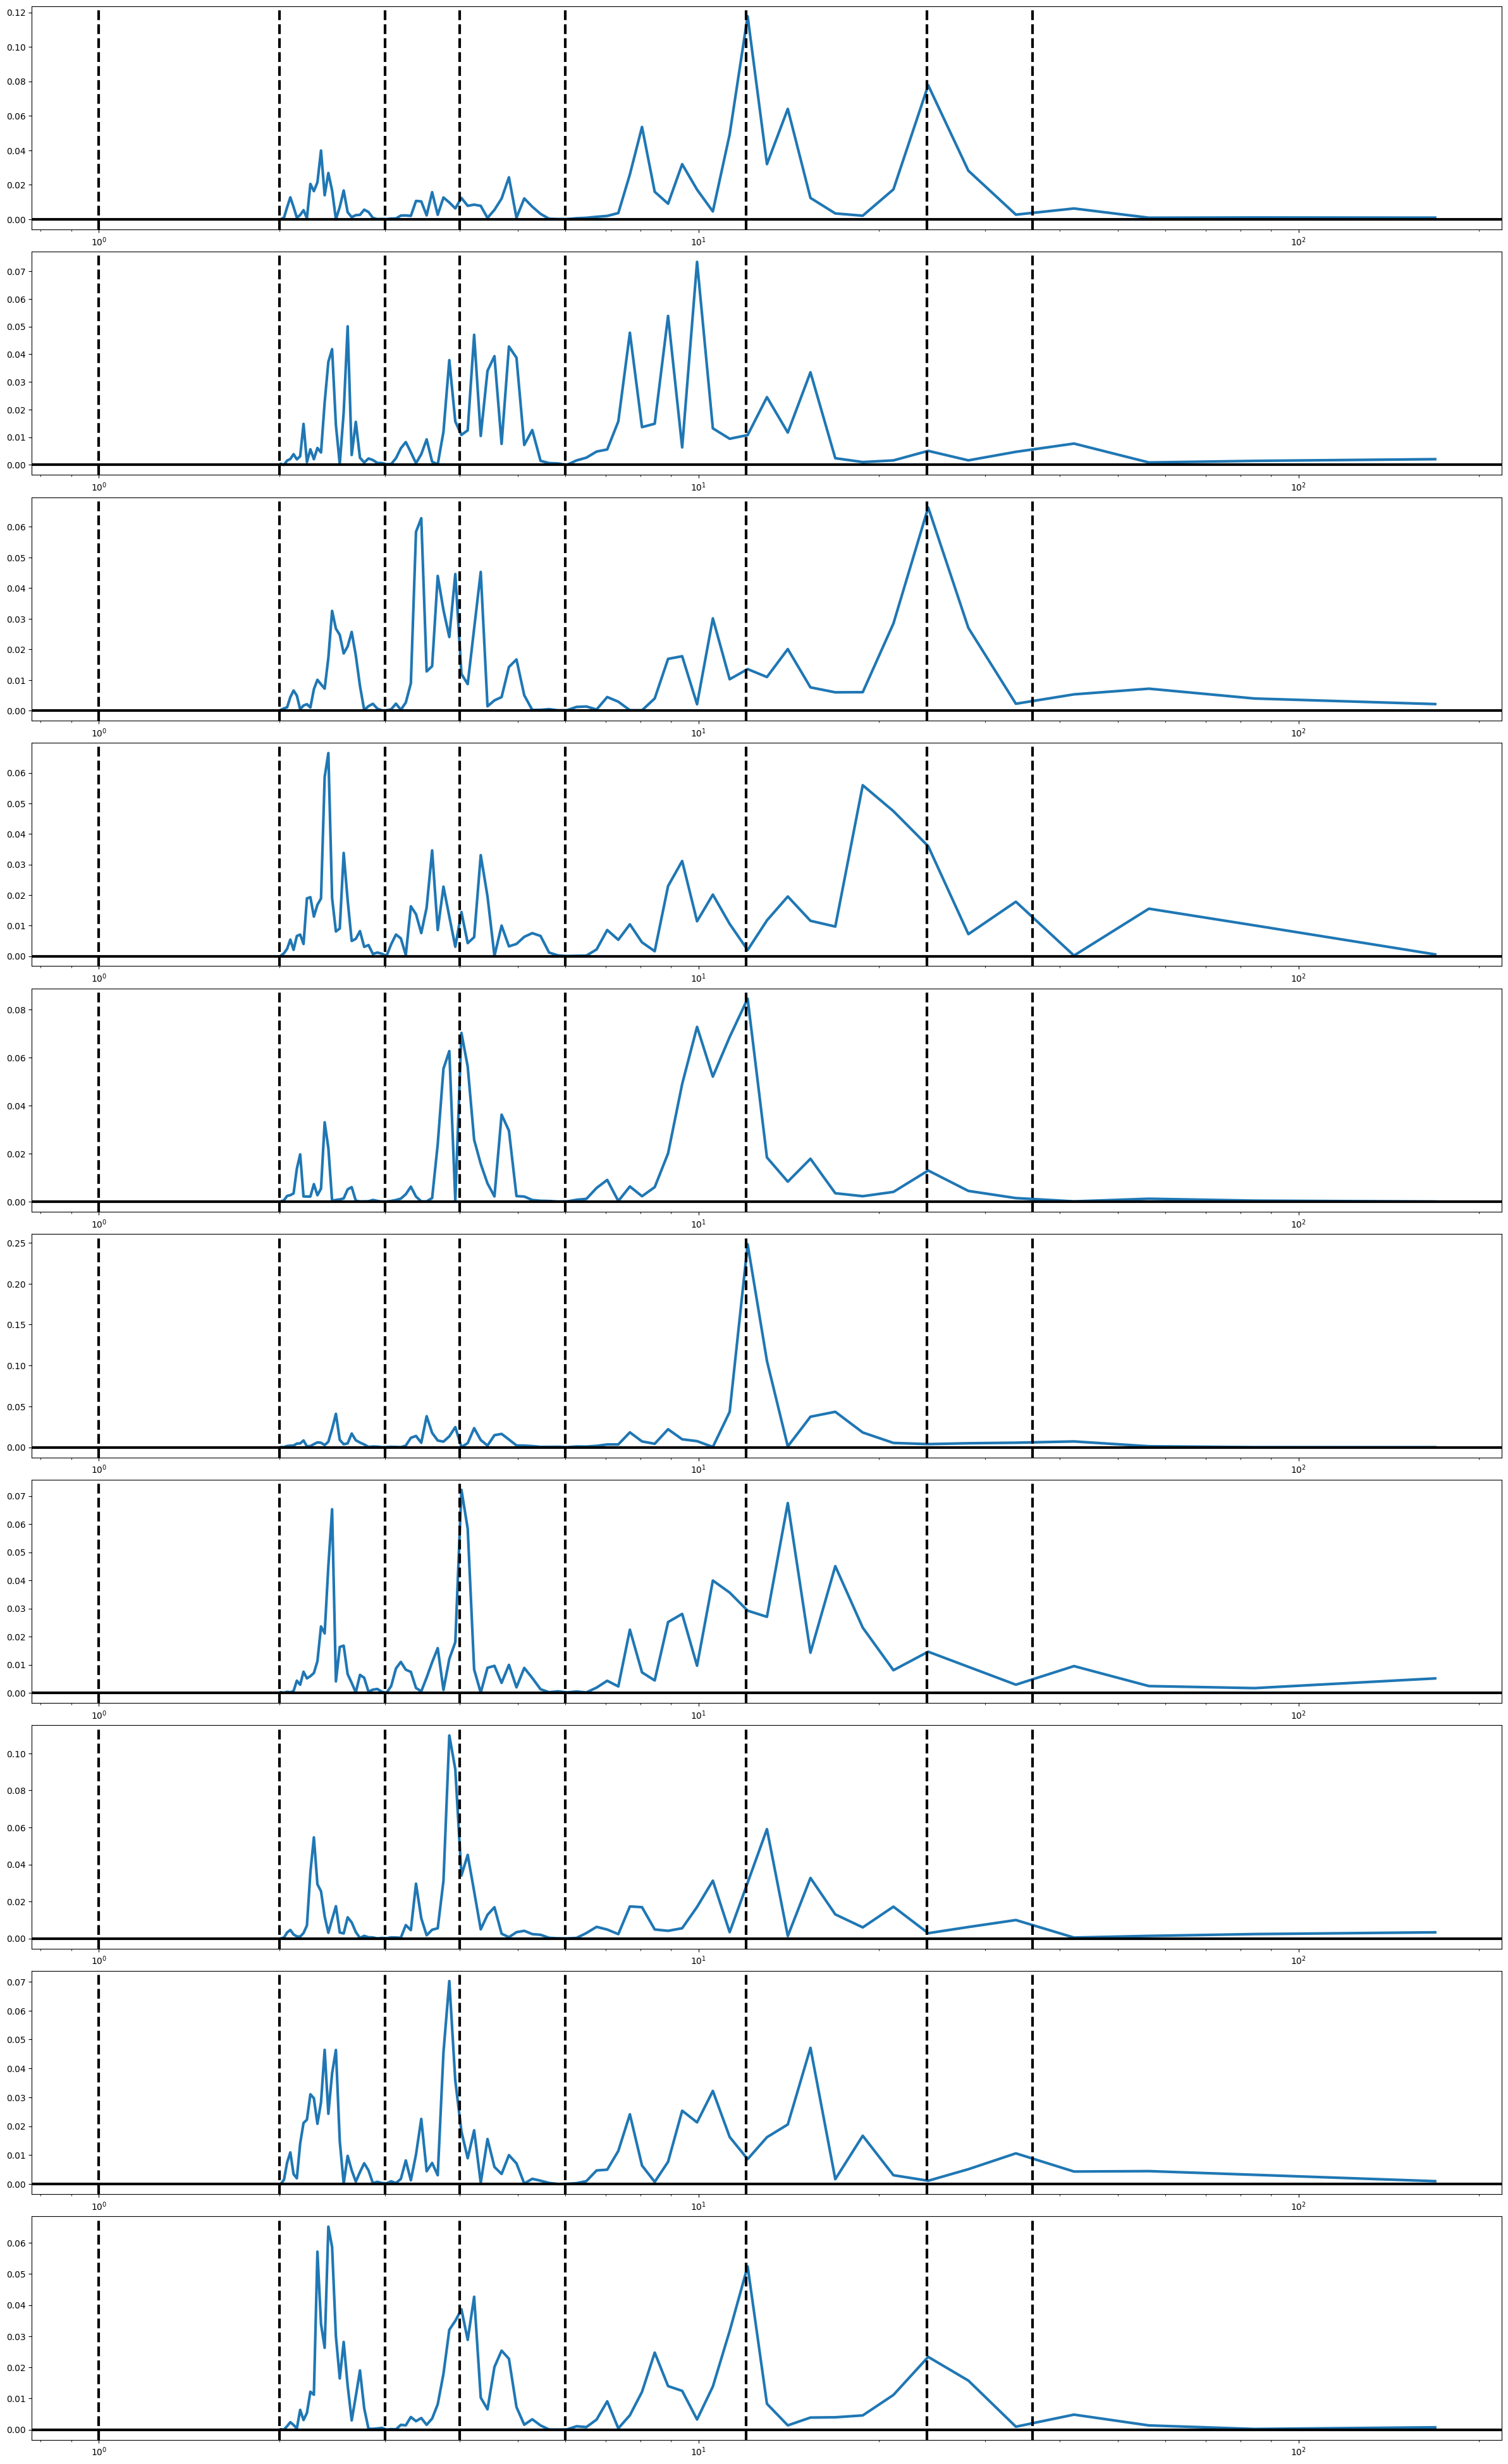

In [323]:
fig, ax = plt.subplots(figsize=(30,5*len(timeLine)), nrows=NTOPICS, gridspec_kw={'hspace':0.1, 'wspace':0.1})
for idx, _ in enumerate(timeLine):
    
    rolling_mean = moving_average(_, 6)
    detrended_mean = np.diff(rolling_mean)

    for step in range(1, 13):
        if step != 1: continue

        # Fourier Transform 
        # xff, yff = fourier_analysis(detrended_mean, sampling_interval=step)
        # ax[idx].plot(1/xff[:], yff[:]/np.sum(yff), lw=3.)
        # print(xff, yff)
   
        # Autocorrelation
        # yff = autoCorrelate(detrended_mean)
        # ax[idx].plot(np.arange(len(yff)), yff)

        # Power Spectral Density
        f, Pxx_den = signal.welch(detrended_mean, fs=step, nperseg=2048)
        ax[idx].plot(1/f, Pxx_den/np.sum(Pxx_den), lw=3.)

        for i in [1, 2, 3, 4, 6, 12, 24, 36]:
            ax[idx].axvline(i, ls='--', lw=3., c='k')
        ax[idx].axhline(0., c='k', lw=3.)

        
    ax[idx].set_xscale('log')
    # ax[idx].set_yscale('log')